## 下载数据集

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib

def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'

    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done.')
    # Remove compressed data
#     os.remove(save_path)

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [ ]:
data_dir = './'
download_extract('ml-1m', data_dir)

Found ml-1m Data


## 数据集信息

### 用户数据
数据中的格式：UserID::Gender::Age::Occupation::Zip-code

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



In [ ]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### 电影数据
数据中的格式：MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [ ]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python', encoding='ISO-8859-1')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### 评分数据
数据中的格式：UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [ ]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 数据预处理

- UserID、Occupation和MovieID不用变。
- Gender字段：需要将‘F’和‘M’转换成0和1。
- Age字段：要转成7个连续数字0~6。
- Genres字段：是分类字段，要转成数字。首先将Genres中的类别转成字符串到数字的字典，然后再将每个电影的Genres字段转成数字列表，因为有些电影是多个Genres的组合。
- Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。
- Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用‘< PAD >’对应的数字填充。

In [ ]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python', encoding='ISO-8859-1')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

### 加载数据并保存到本地

- title_count：Title字段的长度（15）
- title_set：Title文本的集合
- genres2int：电影类型转数字的字典
- features：是输入X
- targets_values：是学习目标y
- ratings：评分数据集的Pandas对象
- users：用户数据集的Pandas对象
- movies：电影数据的Pandas对象
- data：三个数据集组合在一起的Pandas对象
- movies_orig：没有做数据处理的原始电影数据
- users_orig：没有做数据处理的原始用户数据

In [ ]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

### 预处理后的数据

In [ ]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [ ]:
movies.head()

,MovieID,Title,Genres
0,1,"[379, 4155, 3520, 3520, 3520, 3520, 3520, 3520...","[16, 11, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
1,2,"[3806, 3520, 3520, 3520, 3520, 3520, 3520, 352...","[17, 11, 14, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,3,"[3051, 4493, 961, 3520, 3520, 3520, 3520, 3520...","[10, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."
3,4,"[4751, 4045, 2931, 3520, 3520, 3520, 3520, 352...","[10, 18, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9..."
4,5,"[5199, 2772, 1462, 62, 2267, 540, 3520, 3520, ...","[10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,..."


In [ ]:
movies.values[0]

array([1,
       list([379, 4155, 3520, 3520, 3520, 3520, 3520, 3520, 3520, 3520, 3520, 3520, 3520, 3520, 3520]),
       list([16, 11, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])],
      dtype=object)

### 从本地读取数据

In [ ]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

## 模型设计

通过研究数据集中的字段类型，我们发现有一些是类别字段，通常的处理是将这些字段转成one hot编码，但是像UserID、MovieID这样的字段就会变成非常的稀疏，输入的维度急剧膨胀，这是我们不愿意见到的，毕竟我这小笔记本不像大厂动辄能处理数以亿计维度的输入：）

所以在预处理数据时将这些字段转成了数字，我们用这个数字当做嵌入矩阵的索引，在网络的第一层使用了嵌入层，维度是（N，32）和（N，16）。

电影类型的处理要多一步，有时一个电影有多个电影类型，这样从嵌入矩阵索引出来是一个（n，32）的矩阵，因为有多个类型嘛，我们要将这个矩阵求和，变成（1，32）的向量。

从嵌入层索引出特征以后，将各特征传入全连接层，将输出再次传入全连接层，最终分别得到（1，200）的用户特征和电影特征两个特征向量。

我们的目的就是要训练出用户特征和电影特征，在实现推荐功能时使用。得到这两个特征以后，就可以选择任意的方式来拟合评分了。我使用了两种方式，一个是上图中画出的将两个特征做向量乘法，将结果与真实评分做回归，采用MSE优化损失。因为本质上这是一个回归问题，另一种方式是，将两个特征作为输入，再次传入全连接层，输出一个值，将输出值回归到真实评分，采用MSE优化损失。

## 文本卷积网络
网络看起来像下面这样

网络的第一层是词嵌入层，由每一个单词的嵌入向量组成的嵌入矩阵。下一层使用多个不同尺寸（窗口大小）的卷积核在嵌入矩阵上做卷积，窗口大小指的是每次卷积覆盖几个单词。这里跟对图像做卷积不太一样，图像的卷积通常用2x2、3x3、5x5之类的尺寸，而文本卷积要覆盖整个单词的嵌入向量，所以尺寸是（单词数，向量维度），比如每次滑动3个，4个或者5个单词。第三层网络是max pooling得到一个长向量，最后使用dropout做正则化，最终得到了电影Title的特征。

## 辅助函数

In [ ]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


## 编码实现

In [ ]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

### 超参

In [ ]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

### 输入

定义输入的占位符

In [ ]:
def get_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')  
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')  
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age') 
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id') 
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories') 
    movie_titles = tf.keras.layers.Input(shape=(15,), dtype='int32', name='movie_titles') 
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles

## 构建神经网络

#### 定义User的嵌入矩阵

In [ ]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### 将User的嵌入矩阵一起全连接生成User的特征

In [ ]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    #第一层全连接
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    #第二层全连接
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  #(?, 1, 200)

    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)
    return user_combine_layer, user_combine_layer_flat

#### 定义Movie ID的嵌入矩阵

In [ ]:
def get_movie_id_embed_layer(movie_id):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1, name='movie_id_embed_layer')(movie_id)
    return movie_id_embed_layer

#### 合并电影类型的多个嵌入向量

In [ ]:
def get_movie_categories_layers(movie_categories):
    movie_categories_embed_layer = tf.keras.layers.Embedding(movie_categories_max, embed_dim, input_length=18, name='movie_categories_embed_layer')(movie_categories)
    movie_categories_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(movie_categories_embed_layer)
#     movie_categories_embed_layer = tf.keras.layers.Reshape([1, 18 * embed_dim])(movie_categories_embed_layer)

    return movie_categories_embed_layer

#### Movie Title的文本卷积网络实现

In [ ]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    movie_title_embed_layer = tf.keras.layers.Embedding(movie_title_max, embed_dim, input_length=15, name='movie_title_embed_layer')(movie_titles)
    sp=movie_title_embed_layer.shape
    movie_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(movie_title_embed_layer)
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        conv_layer = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(movie_title_embed_layer_expand)
        maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer)
        pool_layer_lst.append(maxpool_layer)
    #Dropout层
    pool_layer = tf.keras.layers.concatenate(pool_layer_lst, 3, name ="pool_layer")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat")(pool_layer)

    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat)
    return pool_layer_flat, dropout_layer

#### 将Movie的各个层一起做全连接

In [ ]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    #第一层全连接
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer)
    movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(movie_categories_embed_layer)

    #第二层全连接
    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat = tf.keras.layers.Reshape([200], name="movie_combine_layer_flat")(movie_combine_layer)
    return movie_combine_layer, movie_combine_layer_flat

In [ ]:
tf.keras.layers

<module 'keras.api._v2.keras.layers' from '/usr/local/lib/python3.9/dist-packages/keras/api/_v2/keras/layers/__init__.py'>

## 构建计算图

In [ ]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = "./models"


class mv_network(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        # 获取输入占位符
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = get_inputs()
        # 获取User的4个嵌入向量
        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender,
                                                                                                   user_age, user_job)
        # 得到用户特征
        user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer,
                                                                             age_embed_layer, job_embed_layer)
        # 获取电影ID的嵌入向量
        movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
        # 获取电影类型的嵌入向量
        movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
        # 获取电影名的特征向量
        pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
        # 得到电影特征
        movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer,
                                                                                movie_categories_embed_layer,
                                                                                dropout_layer)
        # 计算出评分
        # 将用户特征和电影特征做矩阵乘法得到一个预测评分的方案
        inference = tf.keras.layers.Lambda(lambda layer: 
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, movie_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)
        
        # 将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.keras.layers.concatenate([user_combine_layer_flat, movie_combine_layer_flat],
#                                                       1)  # (?, 400)
        # 你可以使用下面这个全连接层，试试效果
        #inference_dense = tf.keras.layers.Dense(64, kernel_regularizer=tf.nn.l2_loss, activation='relu')(
        #    inference_layer)
#         inference = tf.keras.layers.Dense(1, name="inference")(inference_layer)  # inference_dense

        self.model = tf.keras.Model(
            inputs=[uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        # MSE损失，将计算值回归到评分
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

        if tf.io.gfile.exists(MODEL_DIR):
            #             print('Removing existing model dir: {}'.format(MODEL_DIR))
            #             tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        #         self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
        #         self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)  #

    @tf.function
    def train_step(self, x, y):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        #         metrics = 0
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6]], training=True)
            loss = self.ComputeLoss(y, logits)
            # loss = self.compute_loss(labels, logits)
            self.ComputeMetrics(y, logits)
            # metrics = self.compute_metrics(labels, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):

        for epoch_i in range(epochs):
            # 将数据集分成训练集和测试集，随机种子不固定
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size=0.2,
                                                                random_state=0)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            #             with self.train_summary_writer.as_default():
            if True:
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                #                 avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

                # Datasets can be iterated over like any other Python iterable.
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    #                     avg_mae(metrics)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        #                         summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        #                         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=self.optimizer.iterations)
                        # summary_ops_v2.scalar('mae', avg_mae.result(), step=self.optimizer.iterations)

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        # print('Step #{}\tLoss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                        #     self.optimizer.iterations.numpy(), loss, (avg_mae.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        # avg_mae.reset_states()
                        start = time.time()

            train_end = time.time()
            print(
                '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
            #             with self.test_summary_writer.as_default():
            self.testing((test_X, test_y), self.optimizer.iterations)
            # self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        #         avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            # 保存测试损失
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            # avg_loss(self.compute_loss(labels, logits))
            # avg_mae(self.compute_metrics(labels, logits))

        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))
        # print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), avg_mae.result()))
        #         summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        #         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=step_num)
        # summary_ops_v2.scalar('mae', avg_mae.result(), step=step_num)

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)
        # logits = tf.nn.softmax(predictions)

        return predictions


## 取得batch

In [ ]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## 训练网络

将用户特征和电影特征作为输入，经过全连接，输出一个值的训练

In [ ]:
mv_net=mv_network()
mv_net.training(features, targets_values, epochs=5)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie_titles (InputLayer)      [(None, 15)]         0           []                               
                                                                                                  
 movie_title_embed_layer (Embed  (None, 15, 32)      166944      ['movie_titles[0][0]']           
 ding)                                                                                            
                                                                                                  
 reshape (Reshape)              (None, 15, 32, 1)    0           ['movie_title_embed_layer[0][0]']
                                                                                                  
 conv2d (Conv2D)                (None, 14, 1, 8)     520         ['reshape[0][0]']            

将用户特征和电影特征做矩阵乘法得到一个预测评分的训练

In [ ]:
mv_net=mv_network()
mv_net.training(features, targets_values, epochs=5)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie_titles (InputLayer)      [(None, 15)]         0           []                               
                                                                                                  
 movie_title_embed_layer (Embed  (None, 15, 32)      166944      ['movie_titles[0][0]']           
 ding)                                                                                            
                                                                                                  
 reshape_1 (Reshape)            (None, 15, 32, 1)    0           ['movie_title_embed_layer[0][0]']
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 1, 8)     520         ['reshape_1[0][0]']        

## 显示训练Loss

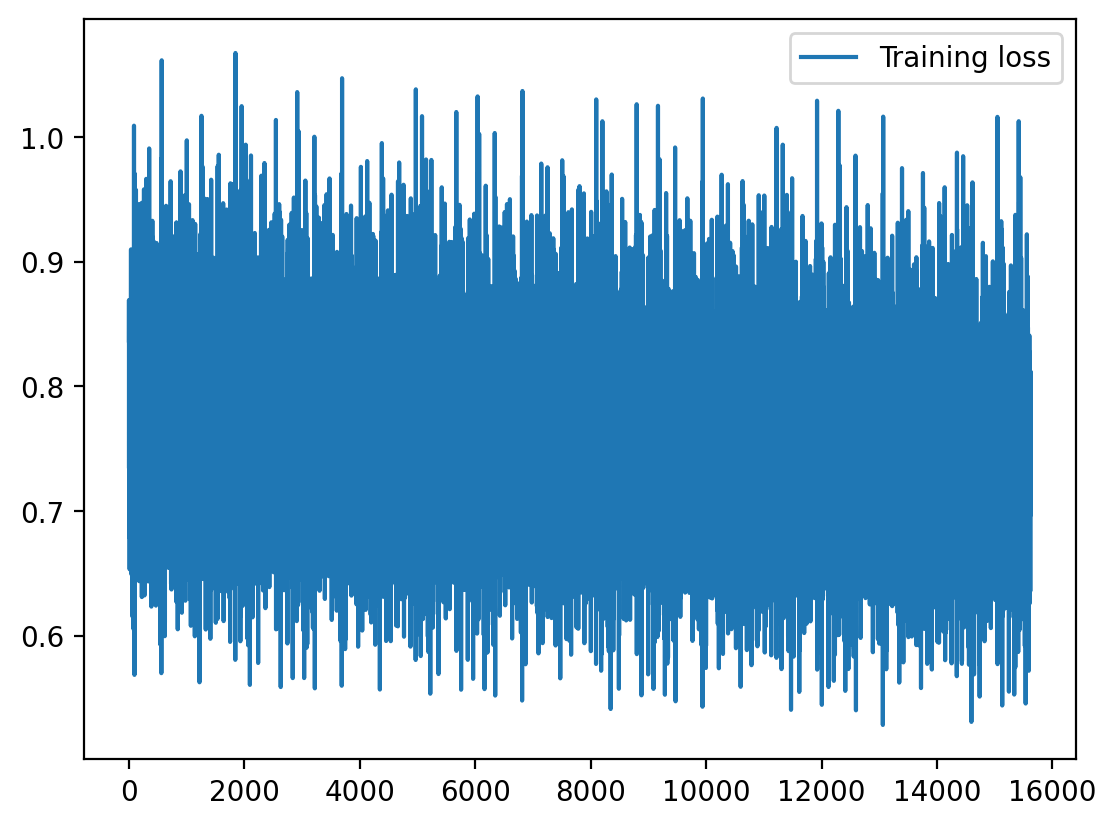

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(mv_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss
迭代次数再增加一些，下降的趋势会明显一些

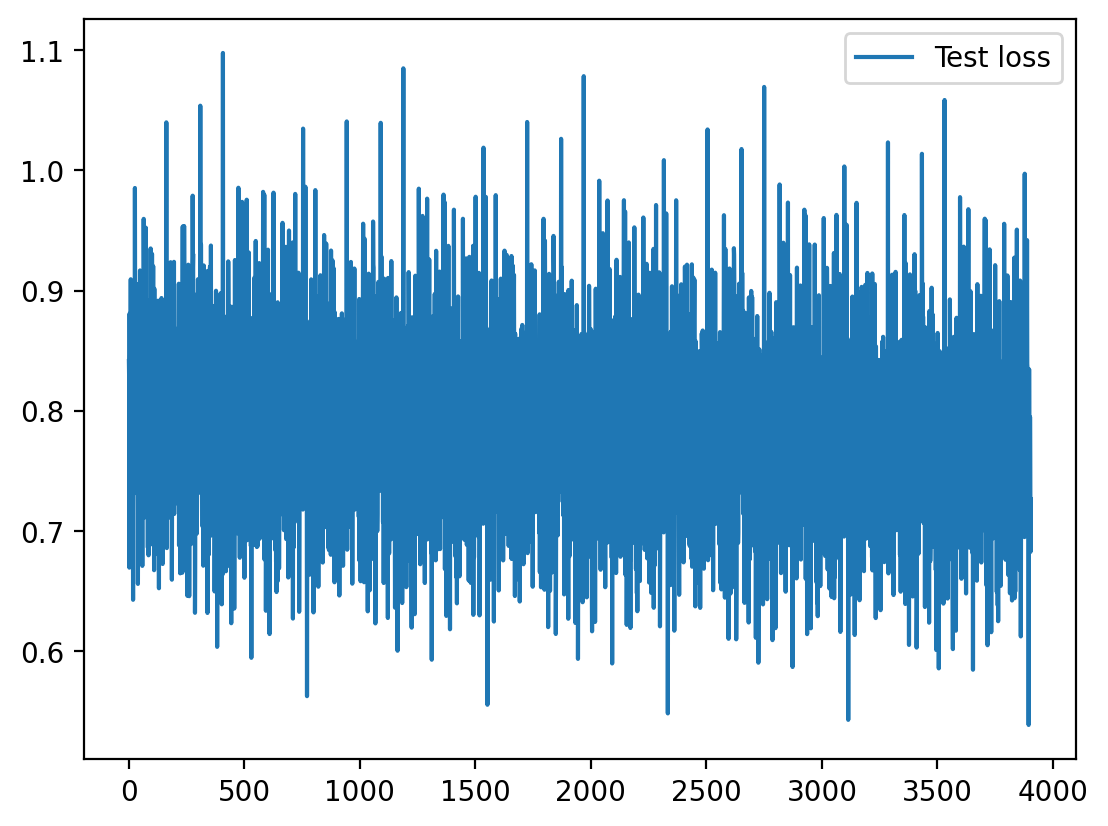

In [ ]:
plt.plot(mv_net.losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 指定用户和电影进行评分
这部分就是对网络做正向传播，计算得到预测的评分

In [ ]:
def rating_movie(mv_net, user_id_val, movie_id_val):
    categories = np.zeros([1, 18])
    categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
    titles = np.zeros([1, sentences_size])
    titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
    inference_val = mv_net.model([np.reshape(users.values[user_id_val-1][0], [1, 1]),
              np.reshape(users.values[user_id_val-1][1], [1, 1]),
              np.reshape(users.values[user_id_val-1][2], [1, 1]),
              np.reshape(users.values[user_id_val-1][3], [1, 1]),
              np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              categories,  
              titles])

    return (inference_val.numpy())

In [ ]:
rating_movie(mv_net, 234, 1401)

array([[4.007099]], dtype=float32)

## 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [ ]:
movie_layer_model = keras.models.Model(inputs=[mv_net.model.input[4], mv_net.model.input[5], mv_net.model.input[6]], 
                                 outputs=mv_net.model.get_layer("movie_combine_layer_flat").output)
movie_matrics = []

for item in movies.values:
    categories = np.zeros([1, 18])
    categories[0] = item.take(2)

    titles = np.zeros([1, sentences_size])
    titles[0] = item.take(1)

    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), categories, titles])  
    movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

In [ ]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

## 生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [ ]:
user_layer_model = keras.models.Model(inputs=[mv_net.model.input[0], mv_net.model.input[1], mv_net.model.input[2], mv_net.model.input[3]], 
                                 outputs=mv_net.model.get_layer("user_combine_layer_flat").output)
users_matrics = []

for item in users.values:

    user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                    np.reshape(item.take(1), [1, 1]), 
                                                    np.reshape(item.take(2), [1, 1]), 
                                                    np.reshape(item.take(3), [1, 1])])  
    users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

In [ ]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

## 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

### 推荐同类型的电影
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [ ]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
   
    norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
    normalized_movie_matrics = movie_matrics / norm_movie_matrics

    #推荐同类型的电影
    probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])
        
    return results

In [ ]:
recommend_same_type_movie(1401, 20)

您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
3040
[3109 'River, The (1984)' 'Drama']
294
[297 'Panther (1995)' 'Drama']
487
[491 'Man Without a Face, The (1993)' 'Drama']
3830
[3900 'Crime and Punishment in Suburbia (2000)' 'Comedy|Drama']
382
[386 'S.F.W. (1994)' 'Drama']


{294, 382, 487, 3040, 3830}

### 推荐您喜欢的电影
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [ ]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    #推荐您喜欢的电影
    probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results

In [ ]:
recommend_your_favorite_movie(234, 10)

以下是给您的推荐：
2693
[2762 'Sixth Sense, The (1999)' 'Thriller']
2128
[2197 'Firelight (1997)' 'Drama']
49
[50 'Usual Suspects, The (1995)' 'Crime|Thriller']
2836
[2905 'Sanjuro (1962)' 'Action|Adventure']
1180
[1198 'Raiders of the Lost Ark (1981)' 'Action|Adventure']


{49, 1180, 2128, 2693, 2836}

### 看过这个电影的人还看了（喜欢）哪些电影
- 首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
- 然后计算这几个人对所有电影的评分
- 选择每个人评分最高的电影作为推荐
- 同样加入了随机选择

In [ ]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):

    probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
    favorite_user_id = np.argsort(probs_user_favorite_similarity.numpy())[0][-top_k:]
    #     print(normalized_users_matrics.numpy().shape)
    #     print(probs_user_favorite_similarity.numpy()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
    print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
    probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
    probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
    p = np.argmax(sim, 1)
    print("喜欢看这个电影的人还喜欢看：")

    if len(set(p)) < 5:
        results = set(p)
    else:
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])
        
    return results

In [ ]:
recommend_other_favorite_movie(1401, 20)

您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[5068 'M' 35 7]
 [1110 'F' 56 6]
 [4144 'M' 18 4]
 [4754 'F' 18 0]
 [567 'M' 35 20]
 [2140 'M' 45 14]
 [214 'M' 18 20]
 [277 'F' 35 1]
 [2696 'M' 25 7]
 [2363 'M' 50 14]
 [2559 'M' 18 10]
 [2496 'M' 50 1]
 [5861 'F' 50 1]
 [2338 'M' 45 17]
 [355 'M' 18 3]
 [451 'M' 56 13]
 [4800 'M' 18 4]
 [3978 'M' 35 13]
 [3901 'M' 18 14]
 [2154 'M' 25 12]]
喜欢看这个电影的人还喜欢看：
2434
[2503 'Apple, The (Sib) (1998)' 'Drama']
847
[858 'Godfather, The (1972)' 'Action|Crime|Drama']
2128
[2197 'Firelight (1997)' 'Drama']
2836
[2905 'Sanjuro (1962)' 'Action|Adventure']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']


{315, 847, 2128, 2434, 2836}

这个结果里面20个人最喜欢这两个电影，所以只输出了两个结果